In [2]:
import numpy as np
import vtk
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
import pygmt
import pandas
os.chdir("../postprocessing_scripts/")
import MORVEL
os.chdir("../main_figures/")

In [3]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, phi, theta

def spherical_to_global_cartesian(r, phi, theta):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

# Loop to create all figures for each thermal model

/Users/danieldouglas/FINAL_SLABS/plate_model/wet/wet_crust/1e20_10kmweak_wet_crust


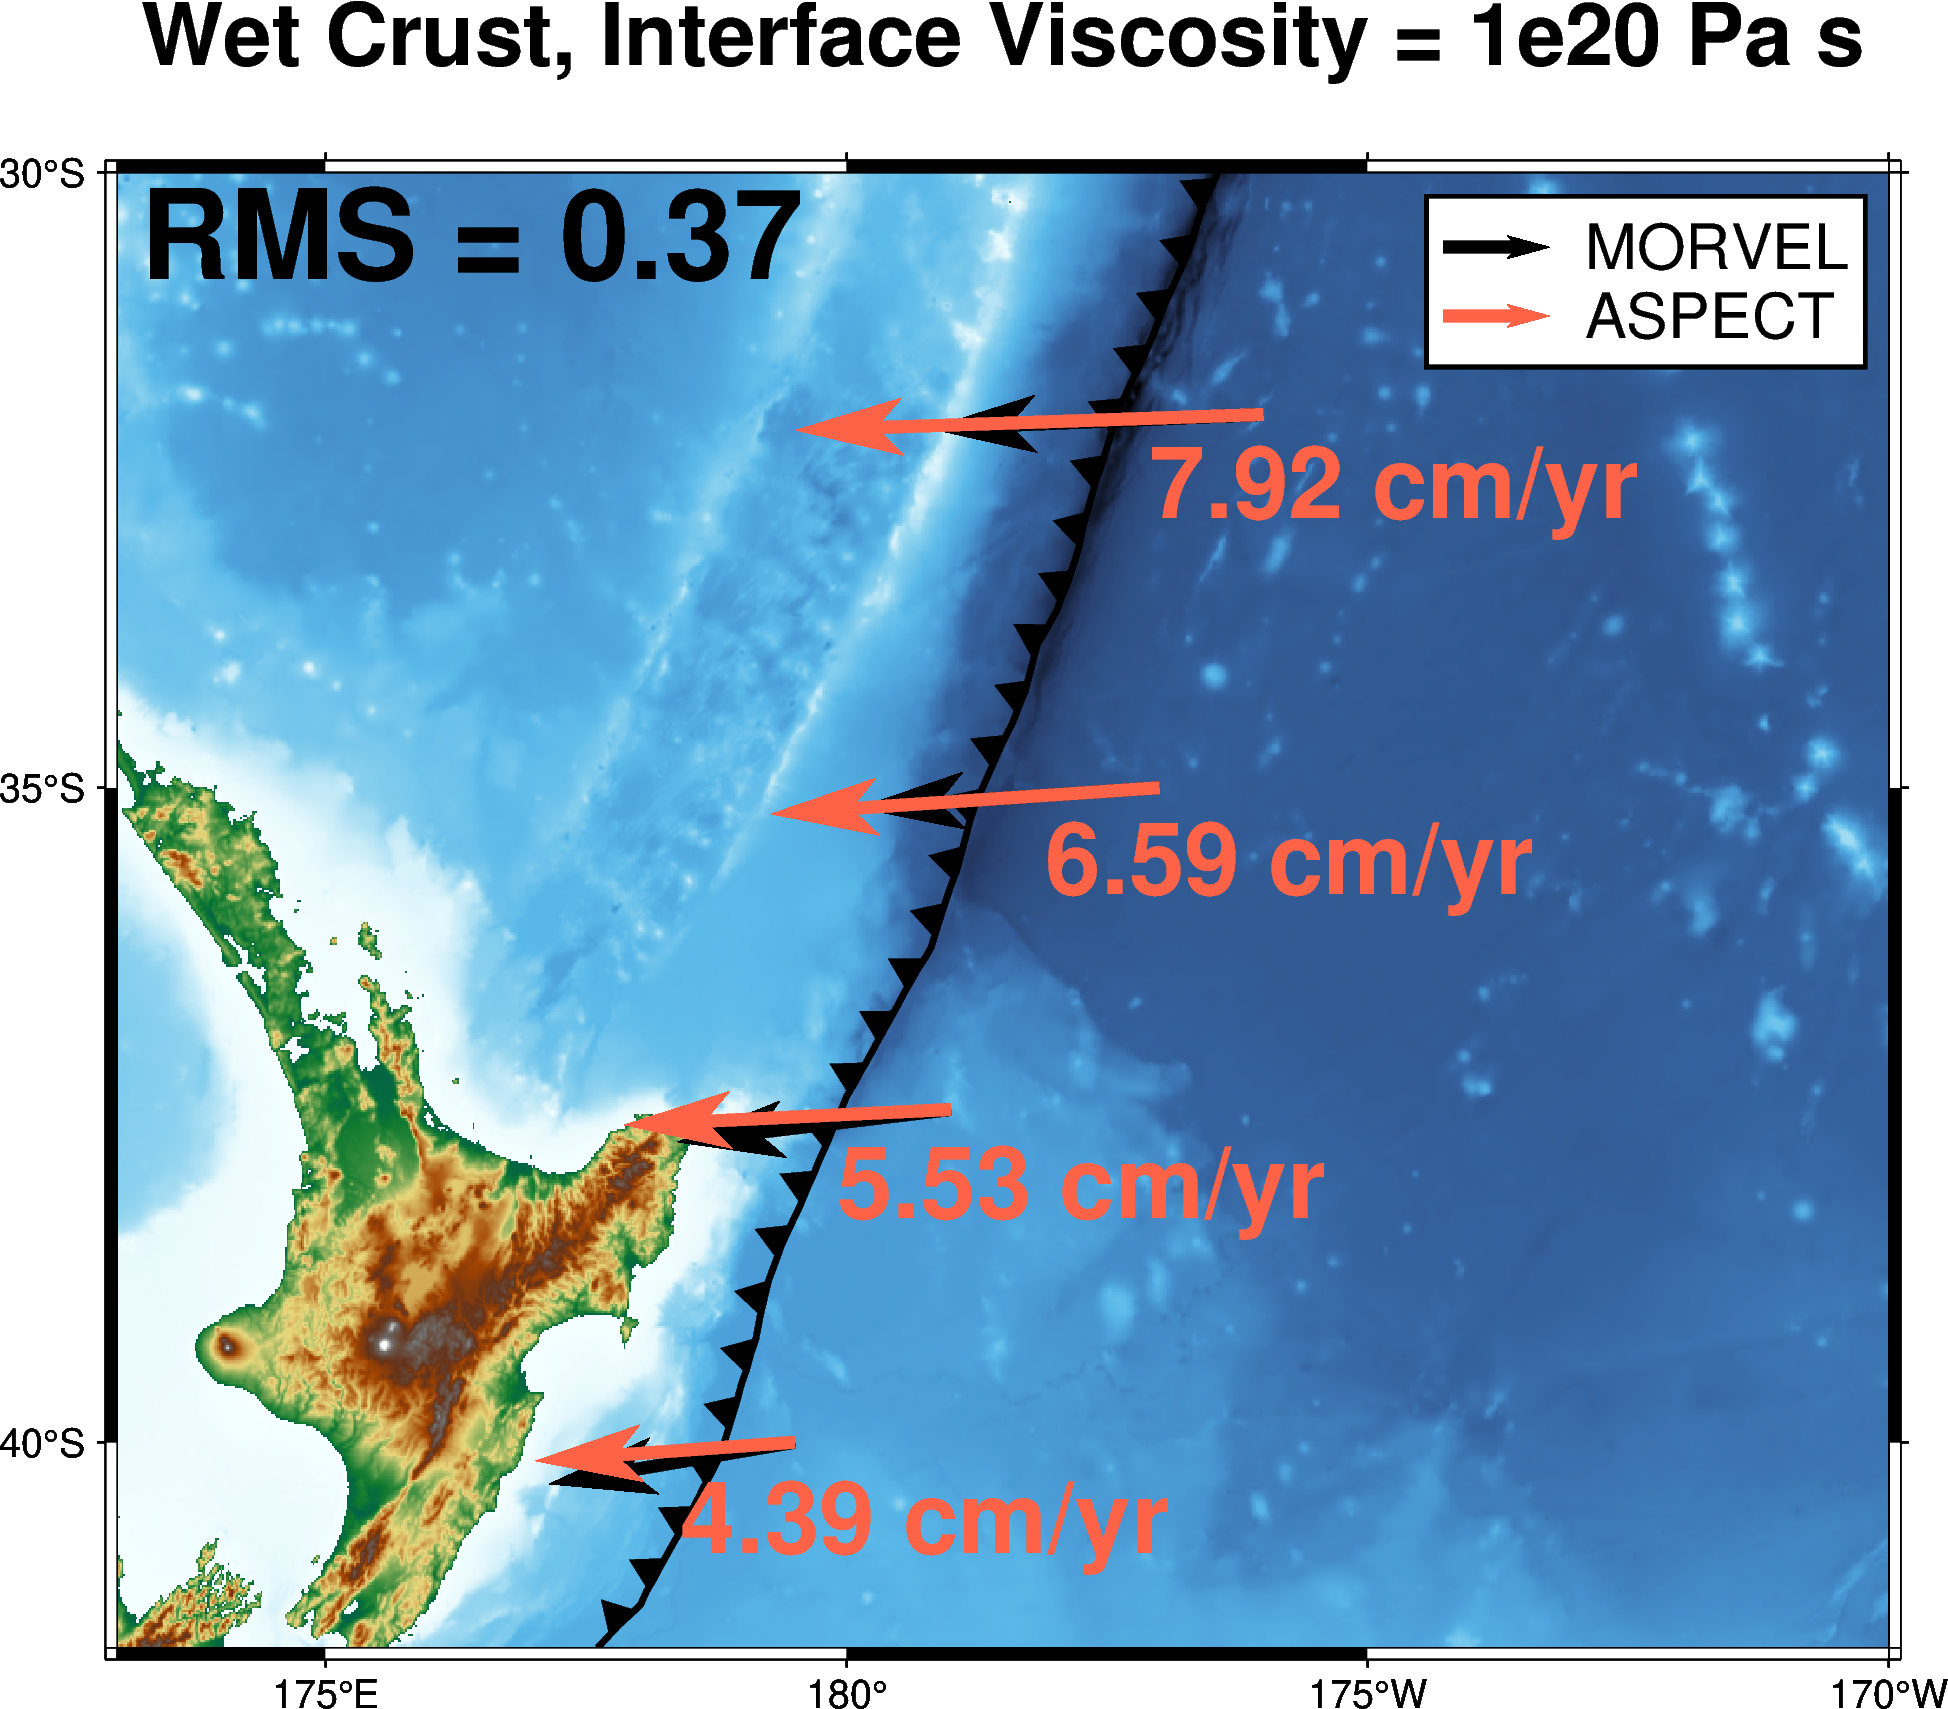

/Users/danieldouglas/FINAL_SLABS/plate_model/wet/wet_crust/1e21_10kmweak_wet_crust


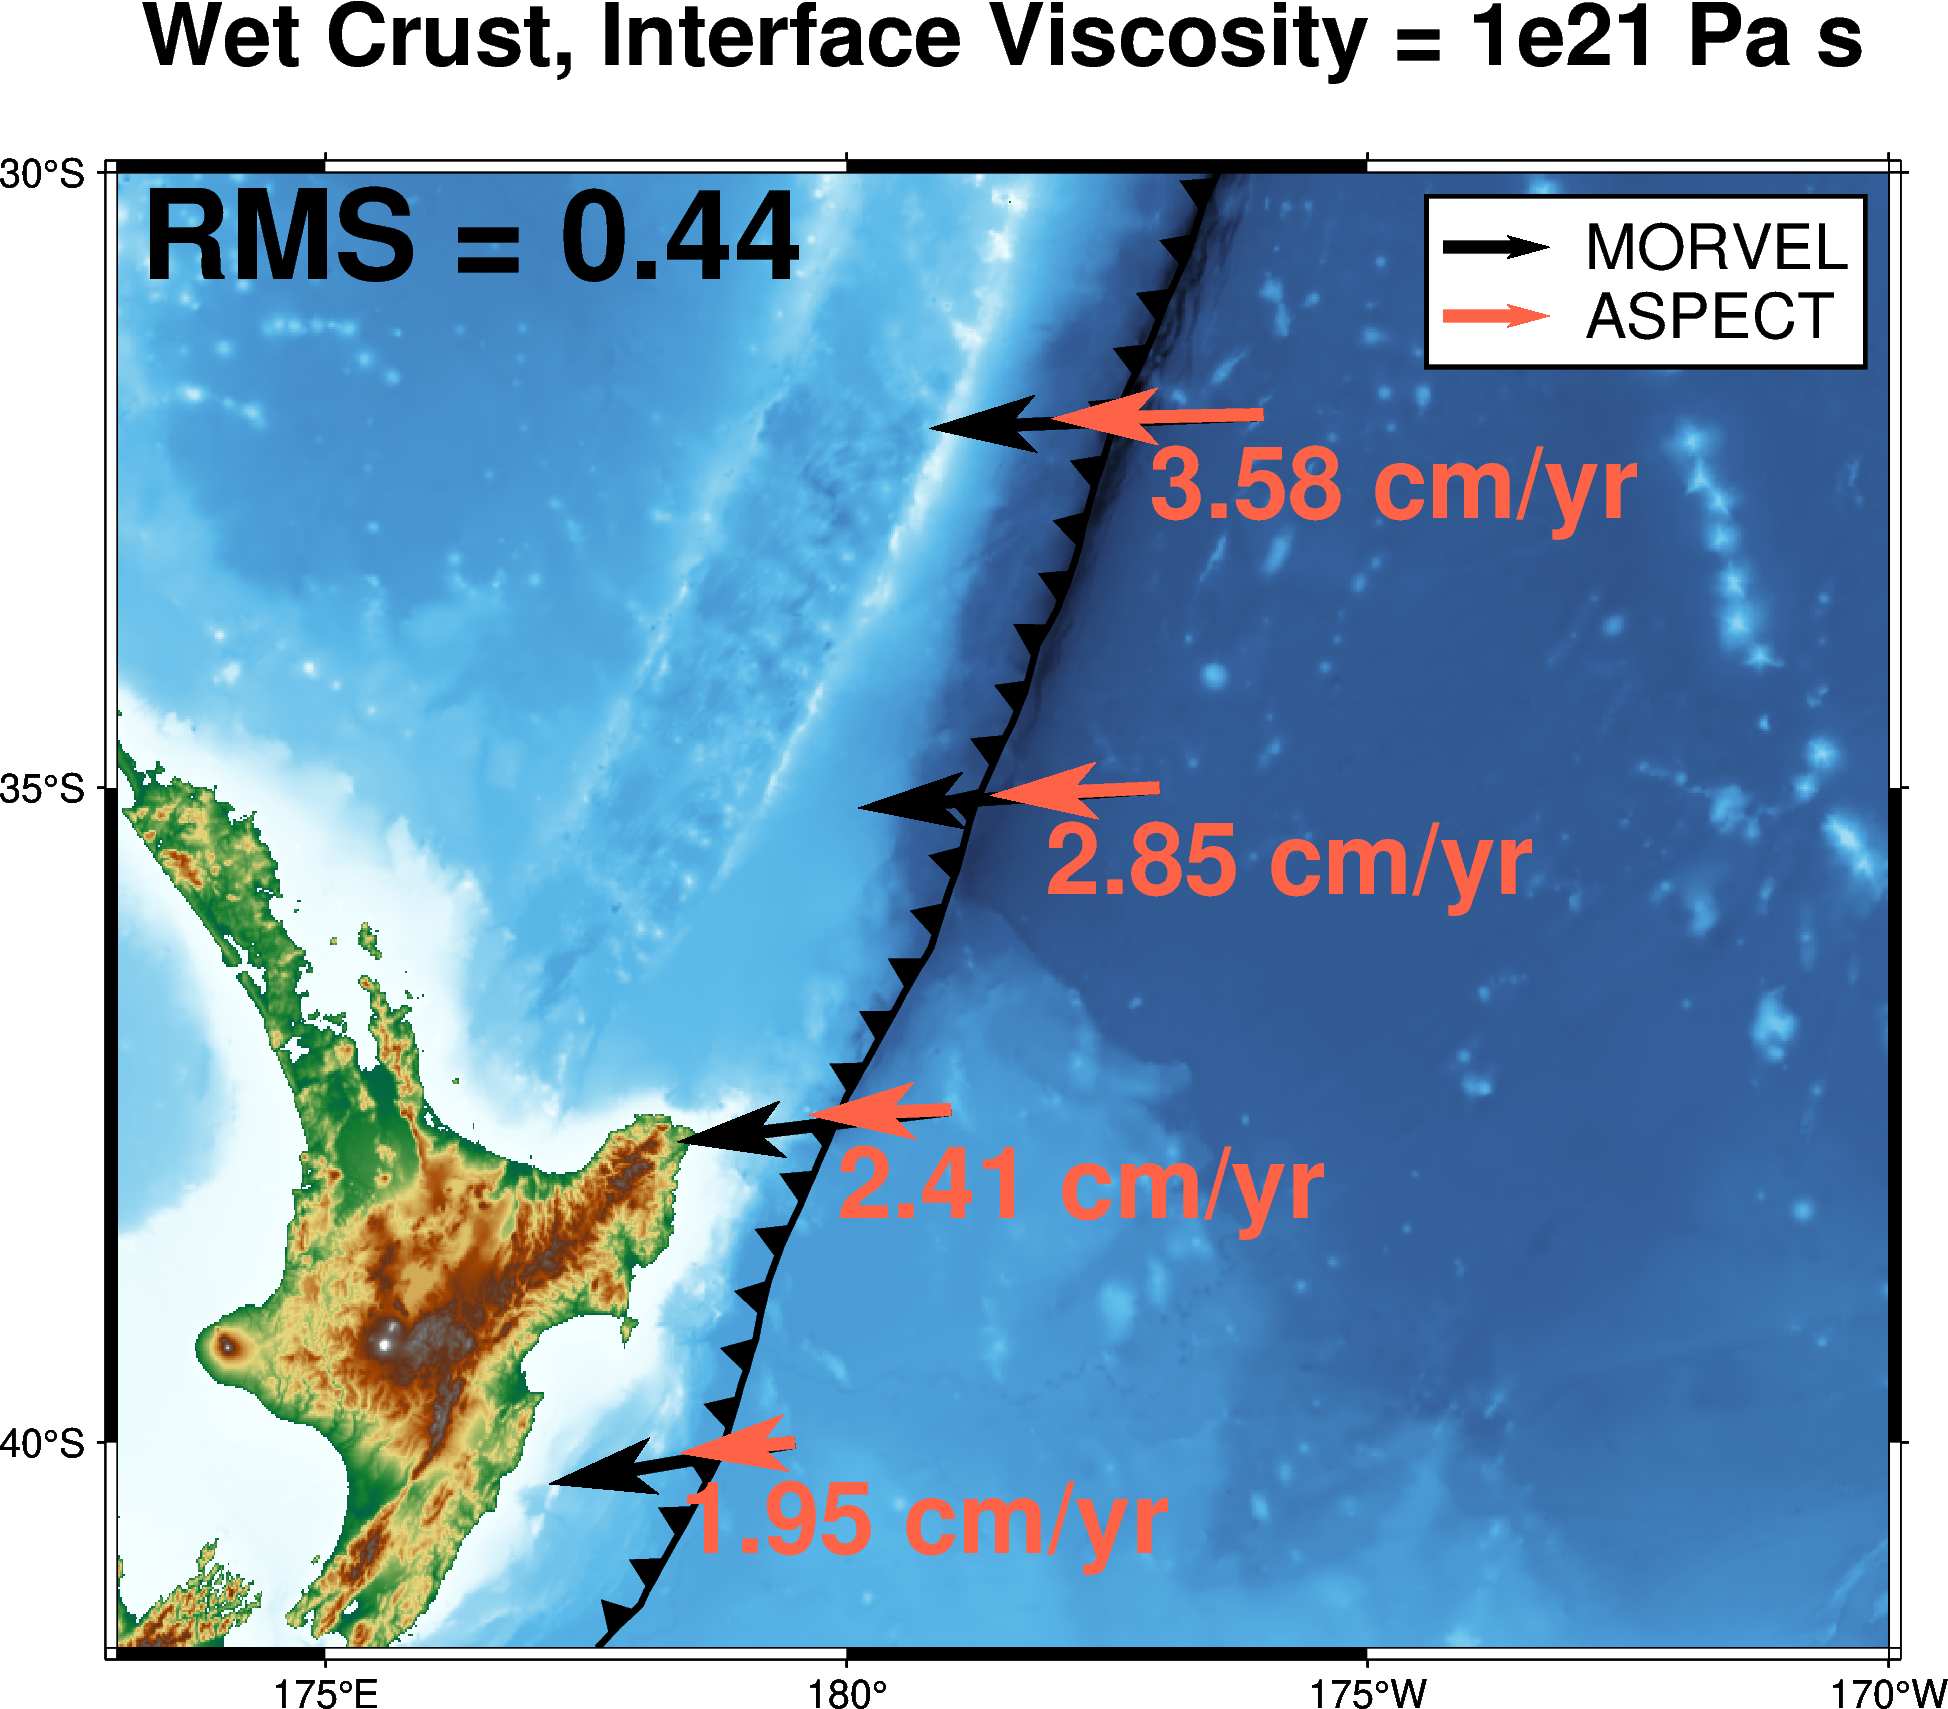

/Users/danieldouglas/FINAL_SLABS/plate_model/wet/wet_crust/5e20_10kmweak_wet_crust


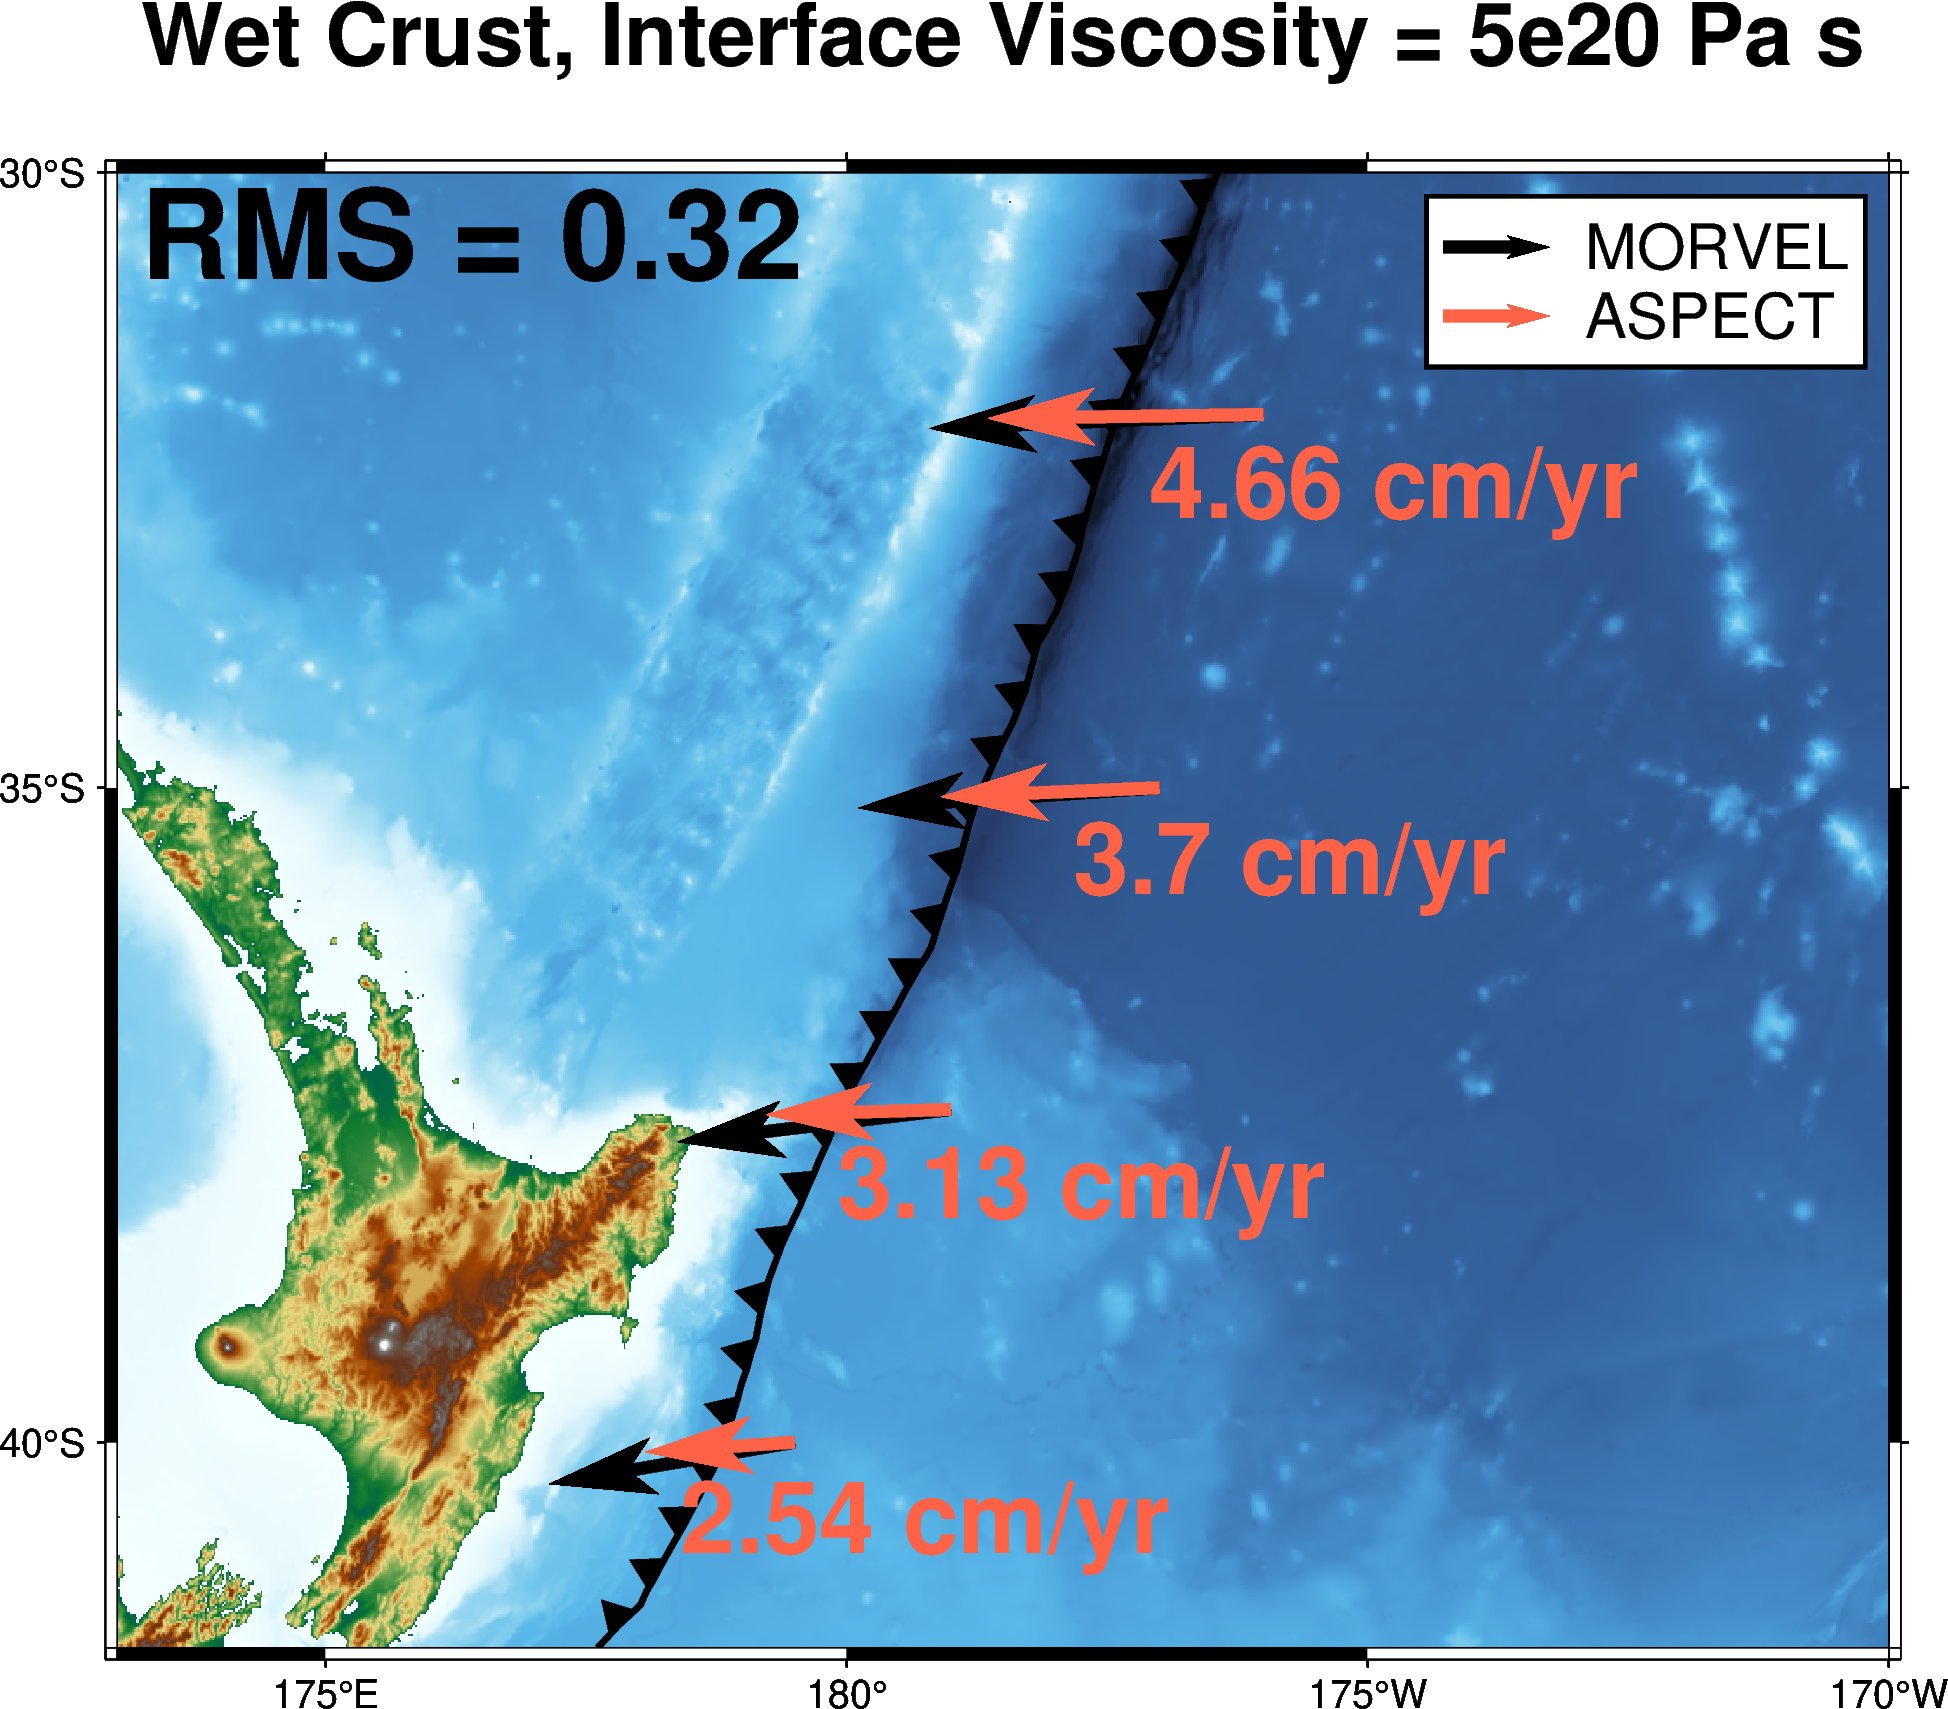

In [17]:
euler_pole_lat = -60.1
euler_pole_lon = -173.7
euler_rotation = 1.079e-6

query_point_lons = np.array([-177, -179, 179.5, -176])
query_point_lats = np.array([-35, -37.5, -40, -32])

point_vels = np.zeros(len(query_point_lons))
point_az = np.zeros(len(query_point_lons))
for i in range(len(query_point_lons)):
    velocity, direction = MORVEL.MORVEL_surface_velocity(euler_pole_lat, euler_pole_lon, euler_rotation, query_point_lats[i], query_point_lons[i])
    point_vels[i] = velocity*100
    point_az[i] = direction

depth = 0
padding = 500

#################################################################################################################################################################################
small_region = [173, 190, -41.5, -30]

# Vector specifications structured as: [x_start, y_start, direction_degrees, length]
vector_1 = [-177, -35, 90 + 93.9, 5.106 / 1.5]
vector_2 = [-179, -37.5, 90 + 96.8, 4.66 / 1.5]
vector_3 = [179.5, -40, 90 + 99.7, 4.21 / 1.5]
vector_4 = [-176, -32, 90 + 92.4, 5.65 / 1.5]


base_directory = "/Users/danieldouglas/FINAL_SLABS/plate_model/"

# rheology = "dry/"
# rheology = "wet/wet_slab/"
# rheology = "wet/wet_upper_mantle/"
rheology = "wet/wet_crust/"

trench = np.loadtxt(fname="../data/trench_contour.csv", delimiter=',')[0:270]
grid = pygmt.datasets.load_earth_relief(resolution="01m", region=small_region)

directory_to_loop = base_directory + rheology
theta_ind = 2
phi_ind = 1

for string in np.sort(os.listdir( directory_to_loop )):
    solution_dir_path = directory_to_loop + string + "/solution/"
    interface_visc = string[0:4]
    print(directory_to_loop + string)
    solutions = np.sort(os.listdir( solution_dir_path ))
    t_step = 0

    if 'pos_solution' in locals():
        del pos_solution, velocity_total, crust_total, litho_total

    for soln in solutions:
        if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
            file_path = os.path.join(solution_dir_path, soln)
            reader = vtkXMLUnstructuredGridReader()
            reader.SetFileName(file_path)
            reader.Update()
            data = reader.GetOutput()
            points = data.GetPoints()
            x = vtk_to_numpy(points.GetData())
            velocity = vtk_to_numpy(data.GetPointData().GetArray('velocity'))
            crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))
            litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))

            if 'pos_solution' in locals():
                pos_solution = np.concatenate( (pos_solution, x) )
                velocity_total = np.concatenate( (velocity_total, velocity) )
                crust_total = np.concatenate( (crust_total, crust) )
                litho_total = np.concatenate( (litho_total, litho) )
            else:
                pos_solution = x
                velocity_total = velocity
                crust_total = crust
                litho_total = litho

    theta, phi, ASPECT_v = MORVEL.ASPECT_surface_velocity(pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2], \
                                                          velocity_total, query_point_lats, query_point_lons, depth, padding)

    ASPECT_spherical_v = MORVEL.velocity_converter(theta, phi, ASPECT_v)
    ASPECT_point_velocity = np.zeros(len(ASPECT_spherical_v))
    ASPECT_point_azimuths = np.zeros(len(ASPECT_spherical_v))
    
    for i in range(len(ASPECT_spherical_v)):
        ASPECT_point_velocity[i] = np.sqrt(ASPECT_spherical_v[i][0]**2 + ASPECT_spherical_v[i][1]**2 + ASPECT_spherical_v[i][2]**2) * 100
        ASPECT_point_azimuths[i] = np.rad2deg(np.arctan(ASPECT_spherical_v[i][theta_ind]/ASPECT_spherical_v[i][phi_ind]))
        if np.sign(ASPECT_spherical_v[i][theta_ind]) >= 0:
            if np.sign(ASPECT_spherical_v[i][phi_ind]) >= 0:
                ASPECT_point_azimuths[i] = -ASPECT_point_azimuths[i]
                ASPECT_point_azimuths[i] += 90
            elif np.sign(ASPECT_spherical_v[i][phi_ind]) < 0:
                ASPECT_point_azimuths[i] = ASPECT_point_azimuths[i]
                ASPECT_point_azimuths[i] += 90
        elif np.sign(ASPECT_spherical_v[i][theta_ind]) < 0:
            if np.sign(ASPECT_spherical_v[i][phi_ind]) < 0:
                ASPECT_point_azimuths[i] = -ASPECT_point_azimuths[i]
                ASPECT_point_azimuths[i] += 270
            elif np.sign(ASPECT_spherical_v[i][phi_ind]) >= 0:
                ASPECT_point_azimuths[i] = ASPECT_point_azimuths[i]
                ASPECT_point_azimuths[i] += 270

    point_vels = np.zeros(len(query_point_lons))
    point_az = np.zeros(len(query_point_lons))
    for i in range(len(query_point_lons)):
        velocity, direction = MORVEL.MORVEL_surface_velocity(euler_pole_lat, euler_pole_lon, euler_rotation, query_point_lats[i], query_point_lons[i])
        point_vels[i] = velocity*100
        point_az[i] = direction

    litho_points = pos_solution[np.where( (crust_total >= 0.5) | (litho_total >= 0.5) )]
    litho_R, litho_phi, litho_theta = cartesian_to_spherical(litho_points[:, 0], litho_points[:, 1], litho_points[:, 2])
    surface_litho_index_w_trench = np.where( (litho_R >= 6361e3) & (litho_theta <= -26) & (litho_theta >= - 42) & (litho_phi <= 190) )
    surface_litho_R_w_trench = litho_R[surface_litho_index_w_trench]
    surface_litho_phi_w_trench = litho_phi[surface_litho_index_w_trench]
    surface_litho_theta_w_trench = litho_theta[surface_litho_index_w_trench]

    surface_litho_phi = np.empty(0)
    surface_litho_theta = np.empty(0)
    trench_lon_buffer = 0.1

    for i in range(len(surface_litho_theta_w_trench)):
        trench_lat_ind = np.abs(trench[:, 1] - surface_litho_theta_w_trench[i]).argmin()
        if surface_litho_phi_w_trench[i] > (trench[trench_lat_ind][0] + trench_lon_buffer):
            surface_litho_phi = np.append(surface_litho_phi, surface_litho_phi_w_trench[i])
            surface_litho_theta = np.append(surface_litho_theta, surface_litho_theta_w_trench[i])

    depth = 0
    padding = 500
    theta, phi, ASPECT_v = MORVEL.ASPECT_surface_velocity(pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2], \
                                                          velocity_total, surface_litho_theta, surface_litho_phi, depth, padding)

    ASPECT_spherical_v = MORVEL.velocity_converter(theta, phi, ASPECT_v)

    v_mag = np.zeros(len(ASPECT_spherical_v))
    ASPECT_azimuths = np.zeros(len(ASPECT_spherical_v))
    for i in range(len(ASPECT_spherical_v)):
        v_mag[i] = np.sqrt(ASPECT_spherical_v[i][0]**2 + ASPECT_spherical_v[i][1]**2 + ASPECT_spherical_v[i][2]**2) * 100
        ASPECT_azimuths[i] = np.rad2deg(np.arctan(ASPECT_spherical_v[i][theta_ind]/ASPECT_spherical_v[i][phi_ind]))
        if np.sign(ASPECT_spherical_v[i][theta_ind]) >= 0:
            if np.sign(ASPECT_spherical_v[i][phi_ind]) >= 0:
                ASPECT_azimuths[i] = -ASPECT_azimuths[i]
                ASPECT_azimuths[i] += 90
            elif np.sign(ASPECT_spherical_v[i][phi_ind]) < 0:
                ASPECT_azimuths[i] = ASPECT_azimuths[i]
                ASPECT_azimuths[i] += 90
        elif np.sign(ASPECT_spherical_v[i][theta_ind]) < 0:
            if np.sign(ASPECT_spherical_v[i][phi_ind]) < 0:
                ASPECT_azimuths[i] = -ASPECT_azimuths[i]
                ASPECT_azimuths[i] += 270
            elif np.sign(ASPECT_spherical_v[i][phi_ind]) >= 0:
                ASPECT_azimuths[i] = ASPECT_azimuths[i]
                ASPECT_azimuths[i] += 270
    
    MORVEL_calc_v, MORVEL_calc_azi = MORVEL.MORVEL_surface_velocity(euler_pole_lat, euler_pole_lon, euler_rotation, surface_litho_theta, surface_litho_phi)
    MORVEL_calc_v *= 100
    velocity_error = np.sqrt((v_mag - MORVEL_calc_v)**2 / (MORVEL_calc_v)**2)
    
    fig = pygmt.Figure()
    if "wet" in rheology:
        if "mantle" in rheology:
            fig.basemap(region=small_region, projection="M15c", \
                        frame=["f", "+tWet UM, Interface Viscosity = " + interface_visc + " Pa s", "xaf+lx-axis", "yaf+ly-axis"])
        elif "crust" in rheology:
            fig.basemap(region=small_region, projection="M15c", \
                        frame=["f", "+tWet Crust, Interface Viscosity = " + interface_visc + " Pa s", "xaf+lx-axis", "yaf+ly-axis"])

        elif "slab" in rheology:
            fig.basemap(region=small_region, projection="M15c", \
                        frame=["f", "+tWet Slab, Interface Viscosity = " + interface_visc + " Pa s", "xaf+lx-axis", "yaf+ly-axis"])
    else:
        fig.basemap(region=small_region, projection="M15c", \
                    frame=["f", "+tDry, Interface Viscosity = " + interface_visc + " Pa s", "xaf+lx-axis", "yaf+ly-axis"])
        
    fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo")
    fig.plot(x=trench[:, 0], y=trench[:, 1], pen="1.5p", style="f0.5c/0.3c+l+t+o0.3c+p", fill='black')

    velocity_fac = 2
    # Vector specifications structured as: [x_start, y_start, direction_degrees, length]
    MORVEL_1 = [-177, -35, 90 + point_az[0], point_vels[0] / velocity_fac]
    MORVEL_2 = [-179, -37.5, 90 + point_az[1], point_vels[1] / velocity_fac]
    MORVEL_3 = [179.5, -40, 90 + point_az[2], point_vels[2] / velocity_fac]
    MORVEL_4 = [-176, -32, 90 + point_az[3], point_vels[3] / velocity_fac]

    ASPECT_1 = [-177, -35, ASPECT_point_azimuths[0], ASPECT_point_velocity[0] / velocity_fac]
    ASPECT_2 = [-179, -37.5, ASPECT_point_azimuths[1], ASPECT_point_velocity[1] / velocity_fac]
    ASPECT_3 = [179.5, -40, ASPECT_point_azimuths[2], ASPECT_point_velocity[2] / velocity_fac]
    ASPECT_4 = [-176, -32, ASPECT_point_azimuths[3], ASPECT_point_velocity[3] / velocity_fac]
    # Create a list of lists that include each vector information
    MORVEL_vectors = [MORVEL_1, MORVEL_2, MORVEL_3, MORVEL_4]
    ASPECT_vectors = [ASPECT_1, ASPECT_2, ASPECT_3, ASPECT_4]

    fig.plot(
        region=small_region,
        data=MORVEL_vectors,
        style="v0.9c+e",
        pen="3p,black",
        fill="black",
        label="MORVEL"
    )

    fig.plot(
        region=small_region,
        data=ASPECT_vectors,
        style="v0.9c+e",
        pen="3p,tomato",
        fill="tomato",
        label="ASPECT"
    )

    fig.text(x=ASPECT_1[0] + 1.25, y=ASPECT_1[1] - 0.55, text=str(np.round(ASPECT_point_velocity[0], 2)) + " cm/yr", font="24p,Helvetica-Bold,tomato")
    fig.text(x=ASPECT_2[0] + 1.25, y=ASPECT_2[1] - 0.55, text=str(np.round(ASPECT_point_velocity[1], 2)) + " cm/yr", font="24p,Helvetica-Bold,tomato")
    fig.text(x=ASPECT_3[0] + 1.25, y=ASPECT_3[1] - 0.55, text=str(np.round(ASPECT_point_velocity[2], 2)) + " cm/yr", font="24p,Helvetica-Bold,tomato")
    fig.text(x=ASPECT_4[0] + 1.25, y=ASPECT_4[1] - 0.55, text=str(np.round(ASPECT_point_velocity[3], 2)) + " cm/yr", font="24p,Helvetica-Bold,tomato")
    fig.text(x=176.4, y=-30.5, text="RMS = " + str(np.round(np.average(velocity_error), 2)), font="30p,Helvetica-Bold,black")
    pygmt.config(FONT_ANNOT_PRIMARY="15p")
    fig.legend()
    if rheology[0:3] == "wet":
        fig.savefig("convergence_rates_figures/vel_" + rheology[4: -1] + "_" + interface_visc + ".png")
    elif rheology[0:3] == "dry":
        fig.savefig("convergence_rates_figures/vel_" + rheology[0: 3] + "_" + interface_visc + ".png")
    fig.show()